In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [4]:
test = pd.read_csv('esco_project_data_with_similarity.csv')

C:\Users\gilnr\Anaconda3\envs\mlcourse\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
test.drop(columns=['Unnamed: 0', 'job_category', 'salary', 'job_href'], inplace=True)
test = test[['similarity_all_titles','job_description']].copy()
test.dropna(inplace=True)
test.rename(columns={'job_description':'description'}, inplace=True)

In [6]:
test.head()

,similarity_all_titles,description
0,front end developer,"We seek flexible people, open to explore diffe..."
1,designer grafico,Somos um projecto editorial e queremos recruta...
2,designer grafico,Procuramos Designer Gráfico para trabalho de c...
3,comercial business acquisition,Somos um estúdio de Design Full Service em exp...
4,gestor marketing,Admite-se para o Departamento de Marketing Ges...


# Preprocess text data
Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:
* Convert all text to lower cases
* Delete all tabulation,spaces, and new lines
* Delete all numericals
* Delete nltk's defined stop words 
* Lemmatize text

In [82]:
from fold_to_ascii import fold as ascii_fold
import re

## Lower case, digits, force ascii
test['description'] = test['description'].apply(lambda x: ascii_fold(x.lower(), 'REMOVE_ME').replace('REMOVE_ME', ''))

## only alpha numeric
test['description'] = test['description'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

## remove double space
test['description'] = test['description'].apply(lambda x: " ".join(x.strip() for x in x.split()))

#remove stop words
stop = stopwords.words('english') + stopwords.words('portuguese')
test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(test.head())

Preprocessed data: 

            similarity_all_titles  \
0             front end developer   
1                designer grafico   
2                designer grafico   
3  comercial business acquisition   
4                gestor marketing   

                                         description  
0  seek flexible people open explore different pr...  
1  projecto editorial queremos recrutar designer ...  
2  procuramos designer grafico criacao recorte im...  
3  estudio design full service expansao procuramo...  
4  admite departamento marketing gestor marketing...  


# Visualize data
In this step, **we will aggregate our data by job titles** in order to visualy detect the most frequent words for each job.

In [83]:
## jda stands for job description aggregated
jda = test.groupby(['similarity_all_titles']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

                                   similarity_all_titles  \
0                                                    aas   
1                                 abap consultant junior   
2                                            abastecedor   
3                 abastecedor aeronaves aeroporto lisboa   
4            abastecedor combustiveis posto galp armamar   
...                                                  ...   
38656  zome expo selecionar consultores mediacao imob...   
38657                              zona sintra pedreiros   
38658                             zoosaky tecnico vendas   
38659                           zootecnico c experiencia   
38660                                             zwitch   

                                             description  
0      deadline date wednesday th august requirement ...  
1      abap consultant f lisboa sysmatch portuguese c...  
2      procuramos dinamica simpatica perfil atendimen...  
3      procu


*** aas ***



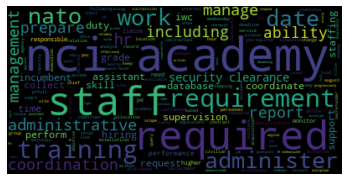


*** abap consultant junior ***



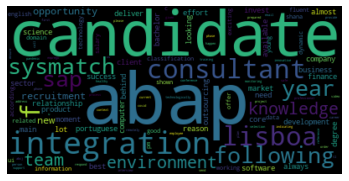


*** abastecedor ***



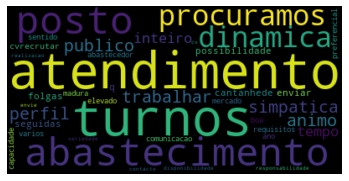


*** abastecedor aeronaves aeroporto lisboa ***



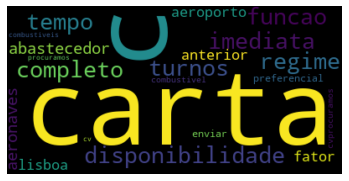


*** abastecedor combustiveis posto galp armamar ***



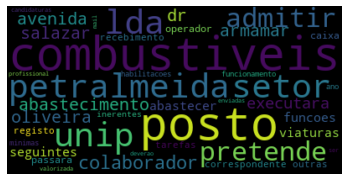

In [84]:
## Visualize data
jobs_list = jda.similarity_all_titles.unique().tolist()
for job in jobs_list[:5]:

    # Start with one review:
    text = jda[jda.similarity_all_titles == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [85]:
## Delete more stop words
other_stop_words = ['junior', 'senior','experience','experiência','etc','empresa', 'trabalho', 'pessoa', 'profissionais', 
                    'procuramos']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

# Modeling
We are now going to translate this skill-extraction problem into a classification one first.
And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title) 

In [86]:
## Converting text to features 
vectorizer = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,2))
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description[:10000])
y = test.similarity_all_titles[:10000]

# split data into 80% training and 20% test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=109) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)
print("train data shape: ",X_train.shape)
print("validation data shape: ",X_val.shape)
print("test data shape: ",X_test.shape)

train data shape:  (2500, 24214)
validation data shape:  (2500, 24214)
test data shape:  (5000, 24214)


In [88]:
vectorizer.get_feature_names()[124:142]

['access public',
 'accessible',
 'accessory',
 'accoes',
 'accommodation',
 'accommodation benefit',
 'accommodation euro',
 'accommodation gross',
 'accommodation one',
 'accommodation shared',
 'accommodation without',
 'accordance',
 'accordance portuguese',
 'according',
 'according case',
 'according jury',
 'according regulation',
 'according table']

In [73]:
# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_val)

In [56]:
# y_train.hist()
# y_test.hist()

# Model Evaluation

In [89]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_val, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_val, y_predicted))
print("Classification Report: ")
print(classification_report(y_val, y_predicted))

Accuracy score is:  0.1008
Classes: (to help read Confusion Matrix)
 ['account agencia video digital' 'account desk officer' 'account manager'
 ... 'yupi promotores' 'yupi promotores comerciais' 'yupi talkaholics']
Confusion Matrix: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report: 
                                                                                            precision    recall  f1-score   support

                                            academia canto vocal emotion procura comercial       0.00      0.00      0.00         1
                                                                         account comercial       0.00      0.00      0.00         1
                                                                            account junior       0.00      0.00      0.00         1
                                                                           account manager   

C:\Users\gilnr\Anaconda3\envs\mlcourse\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gilnr\Anaconda3\envs\mlcourse\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gilnr\Anaconda3\envs\mlcourse\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
